# Horizontal Mean difference and RMS: model versus observations

`mom6_tools.horizontalMean` collection of functions for computing horizontal mean of **difference** and **rms** (model versus obs). This notebook servers as an example on how to compute the following operations:


$$diff(t,z)= A_{TOT}(z)^{-1}\sum_{i=1}^n (y_i(z) - \hat{y_i(x,y,z)}) A_i(z),$$

$$rms(t,z)= [A_{TOT}(z)^{-1}\sum_{i=1}^n (y_i(z) - \hat{y_i}(x,y,z))^2 A_i(z)]^{1/2},$$

where $y$(z) is the model output at point $i$ and level $z$, $\hat{y}(z)$ is the observation at point $i$ and level $z$, $n$ is the total number of grid points in the horizontal (i.e., NX x NY), $A_{i}(z)$ is the area of grid cell $i$ at level $z$, and $A_{TOT}(z) = \sum_{i=1}^n A_i(z)$ is the total ocean area at level z. 

**Important**:

With the porpuses of calculating T and S changes at specific regions, $A_{i}(z)$ is multiplied by basin masks generated via ``mom6_tools.m6toolbox.genBasinMasks``. See [notebook](https://mom6-tools.readthedocs.io/en/latest/examples/region_masks.html) showing how to generate these masks. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.drift import HorizontalMeanDiff_da 
from mom6_tools.m6plot import ztplot
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
from mom6_tools.m6toolbox import genBasinMasks, request_workers, \
                                 weighted_temporal_mean, add_global_attrs
from IPython.display import display, Markdown, Latex
import yaml, intake, os
import xarray as xr
import matplotlib
import numpy as np
%matplotlib inline

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

# load avg dates
avg = diag_config_yml['Avg']

# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
DOUT_S = dcase.get_value('DOUT_S')
if DOUT_S:
  OUTDIR = dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = dcase.get_value('RUNDIR')

print('Output directory is:', OUTDIR)
print('Casename is:', dcase.casename)

Output directory is: /glade/scratch/gmarques/archive/g.e23_b15.GJRAv4.TL319_t232_zstar_N65.baseline.001/ocn/hist/
Casename is: g.e23_b15.GJRAv4.TL319_t232_zstar_N65.baseline.001


In [4]:
# The following parameters must be set accordingly
######################################################

# create an empty class object
class args:
  pass

args.start_date = avg['start_date']
args.end_date = avg['end_date']
args.casename = dcase.casename
args.obs = "woa-2018-tx2_3v2-annual-all"
args.z = dcase.casename+diag_config_yml['Fnames']['z']
args.static = dcase.casename+diag_config_yml['Fnames']['static']
args.savefigs = False
args.nw = 6 # requesting 6 workers

In [5]:
# read grid info
grd = MOM6grid(OUTDIR+'/'+args.static, xrformat=True)
try:
  depth = grd.depth_ocean.values
except:
  depth = grd.deptho.values

try:
  area = grd.area_t.where(grd.wet > 0)
except:
  area = grd.areacello.where(grd.wet > 0)

MOM6 grid successfully loaded... 



In [6]:
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon.values, grd.geolat.values, depth, xda=True)

In [7]:
cluster = NCARCluster()
cluster.scale(args.nw)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.78:42169,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
def preprocess(ds):
    if 'thetao' not in ds.variables:
        ds["thetao"] = xr.zeros_like(ds.h)
    if 'so' not in ds.variables:
        ds["so"] = xr.zeros_like(ds.h)

    return ds

In [9]:
# read dataset
ds = xr.open_mfdataset(OUTDIR+'/'+args.z,
    parallel=True,
    combine="nested", # concatenate in order of files
    concat_dim="time", # concatenate along time
    preprocess=preprocess,
    ).chunk({"time": 12})

In [10]:
# Compute thetao climatologies
var = 'thetao'
attrs =  {
         'description': 'Annual mean climatology for '+var,
         'start_date': args.start_date,
         'end_date': args.end_date,
         'reduction_method': 'annual mean weighted by days in each month',
         'casename': dcase.casename
         }

thetao_model = weighted_temporal_mean(ds,var)
thetao_model.attrs = attrs

In [11]:
# Compute thetao climatologies
var = 'so'
attrs =  {
         'description': 'Annual mean climatology for '+var,
         'start_date': args.start_date,
         'end_date': args.end_date,
         'reduction_method': 'annual mean weighted by days in each month',
         'casename': dcase.casename
         }

salt_model = weighted_temporal_mean(ds,var)
salt_model.attrs = attrs

In [12]:
# load obs
catalog = intake.open_catalog(diag_config_yml['oce_cat'])
obs = catalog[args.obs].to_dask()

In [13]:
temp_diff = thetao_model - obs.thetao
salt_diff = salt_model - obs.so

## Construct a 3D area with land values masked

In [14]:
area3d = np.repeat(area.values[np.newaxis, :, :], len(temp_diff.z_l), axis=0)
mask3d = xr.DataArray(area3d, dims=(temp_diff.dims[1:4]), coords= {temp_diff.dims[1]: temp_diff.z_l,
                                                                   temp_diff.dims[2]: temp_diff.yh,
                                                                   temp_diff.dims[3]: temp_diff.xh})
area3d_masked = mask3d.where(temp_diff[0,:] == temp_diff[0,:])

## Horizontal Mean difference (model - obs)

In [15]:
temp_bias = HorizontalMeanDiff_da(temp_diff,weights=area3d_masked, basins=basin_code)

CPU times: user 1min 35s, sys: 10.1 s, total: 1min 45s
Wall time: 16min 16s


In [16]:
print('Saving temp_bias...\n')
if not os.path.isdir('ncfiles'):
      os.system('mkdir -p ncfiles')
 
var = 'thetao'
attrs = {'casename': dcase.casename,
         'description': 'Annual mean bias for '+var,
         'obs': args.obs
        }

add_global_attrs(temp_bias,attrs)
temp_bias.to_netcdf('ncfiles/'+str(dcase.casename)+'_{}_drift.nc'.format(var))

Saving temp_bias...



## Temperature

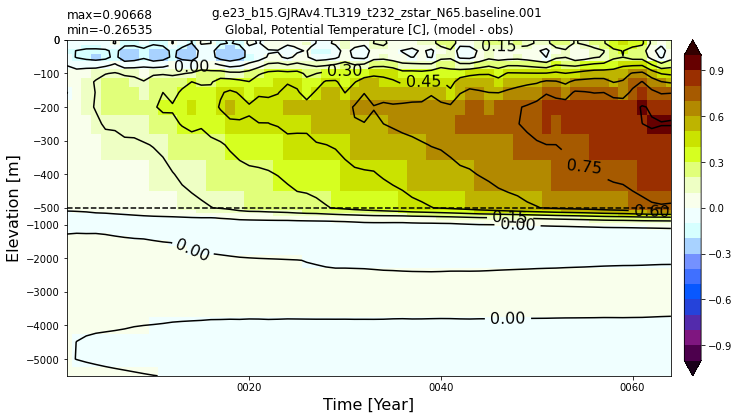

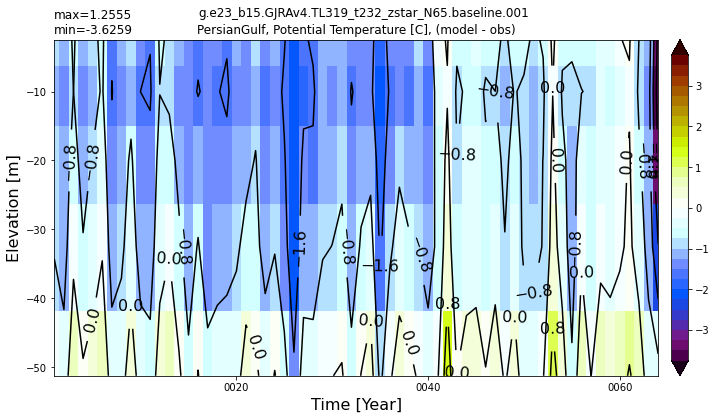

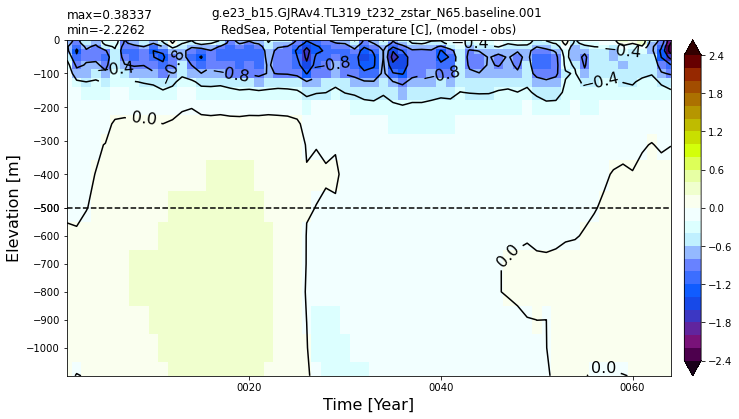

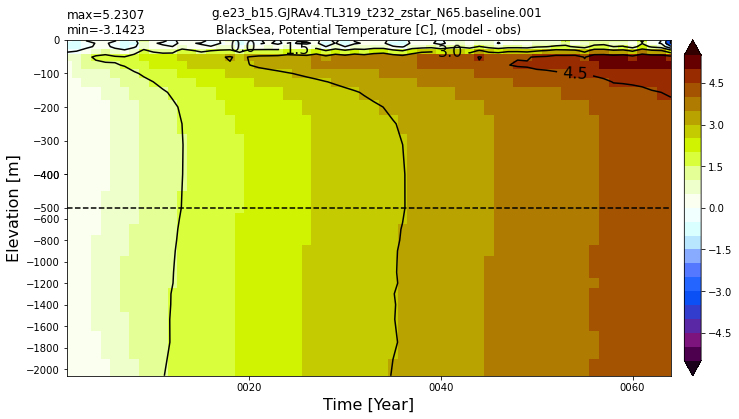

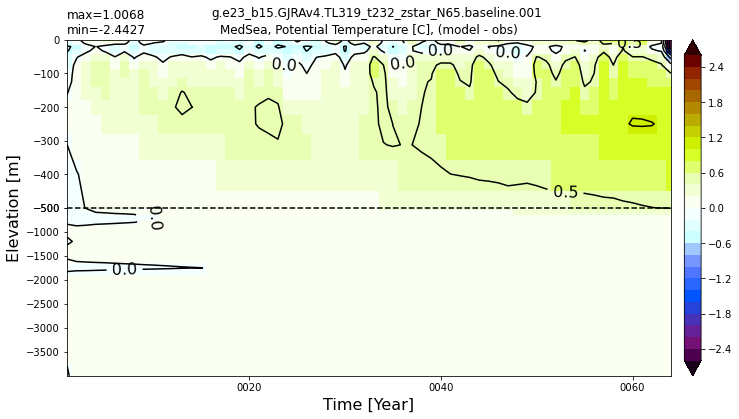

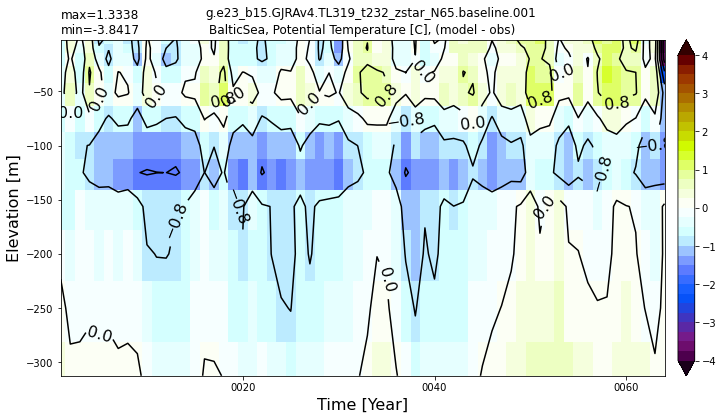

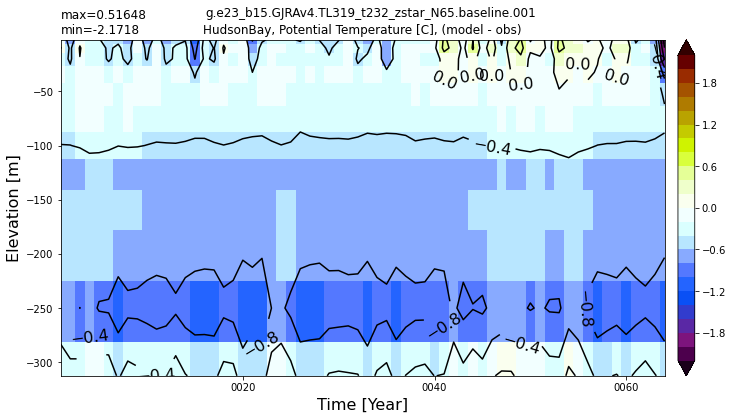

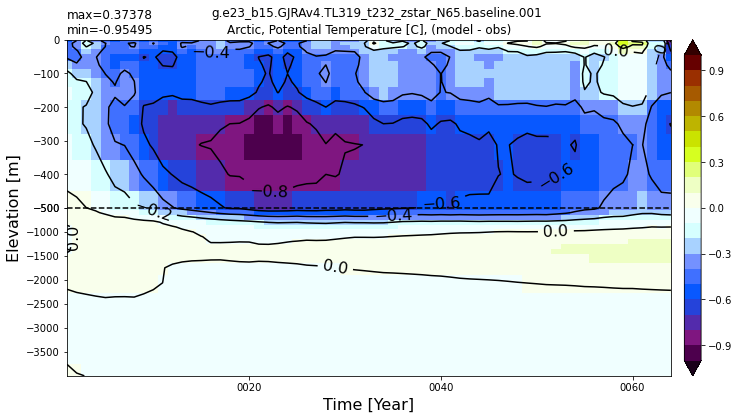

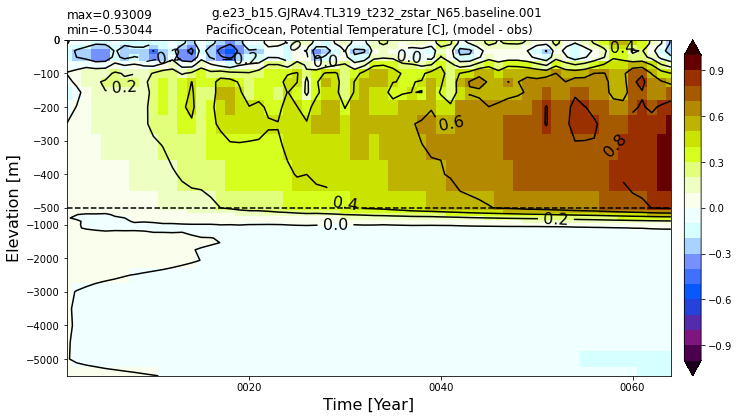

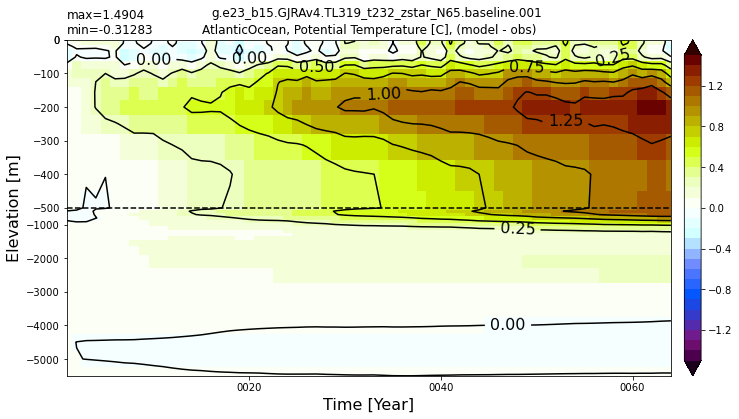

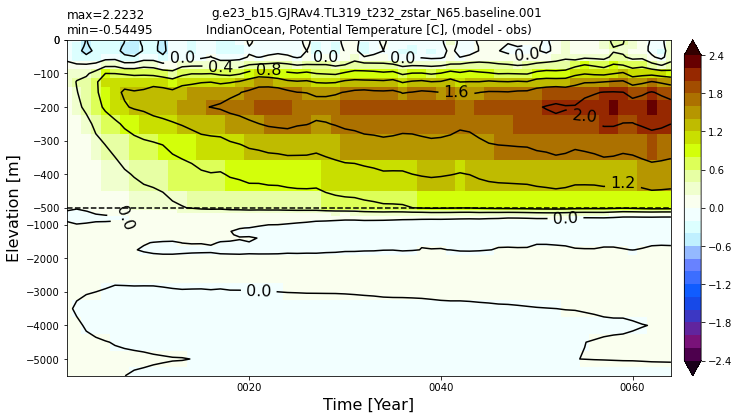

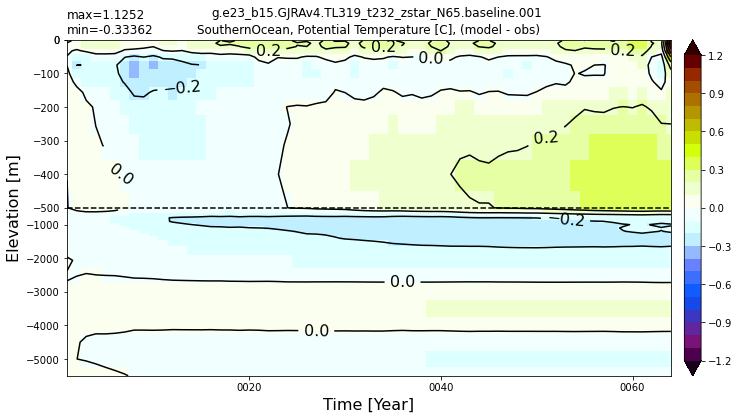

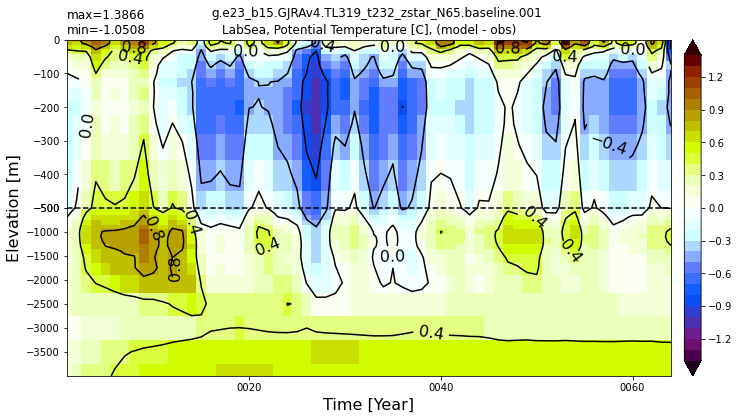

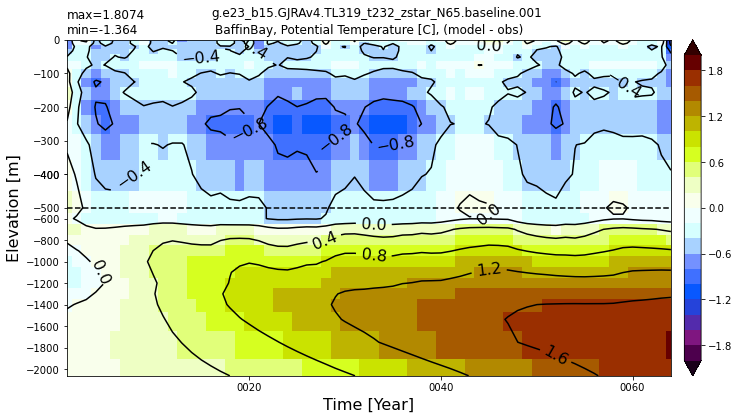

In [17]:
for reg in temp_bias.region:
    # remove Nan's
    diff_reg = temp_bias.sel(region=reg).dropna('z_l')
    if diff_reg.z_l.max() <= 500.0:
      splitscale = None
    else:
      splitscale =  [0., -500., -diff_reg.z_l.max()]

    ztplot(diff_reg.values, diff_reg.time.values, diff_reg.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
           suptitle=dcase._casename, contour=True,
           title= str(reg.values) + ', Potential Temperature [C], (model - obs)', 
           extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=True) 

In [18]:
salt_bias = HorizontalMeanDiff_da(salt_diff,weights=area3d_masked, basins=basin_code)

CPU times: user 1min 38s, sys: 8.78 s, total: 1min 47s
Wall time: 14min 54s


In [19]:
print('Saving salt_bias...\n')
if not os.path.isdir('ncfiles'):
      os.system('mkdir -p ncfiles')
 
var = 'so'
attrs = {'casename': dcase.casename,
         'description': 'Annual mean bias for '+var,
         'obs': args.obs
        }

add_global_attrs(salt_bias,attrs)
salt_bias.to_netcdf('ncfiles/'+str(dcase.casename)+'_{}_drift.nc'.format(var))

Saving salt_bias...



## Salinity

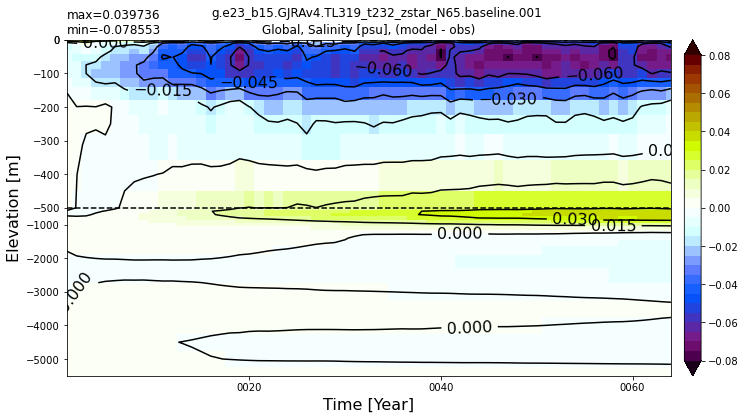

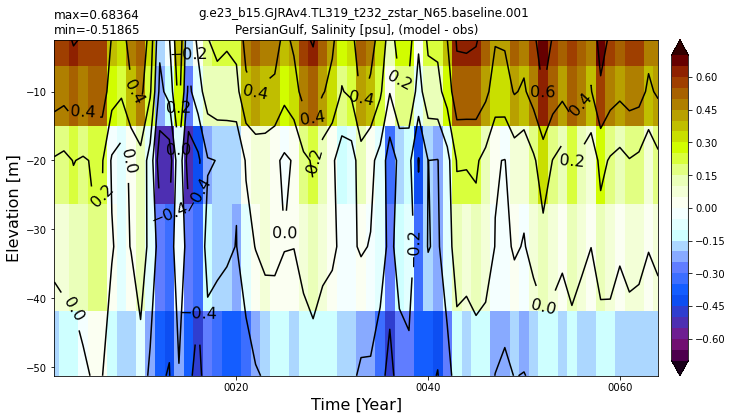

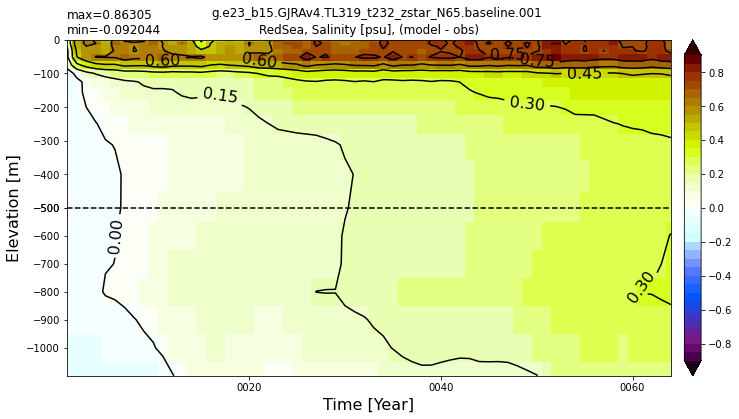

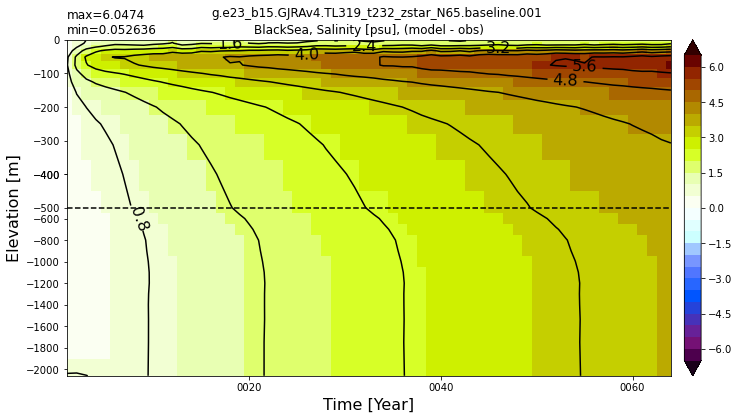

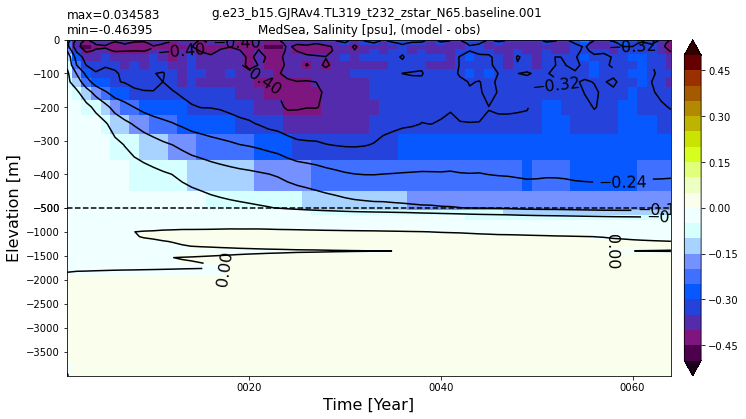

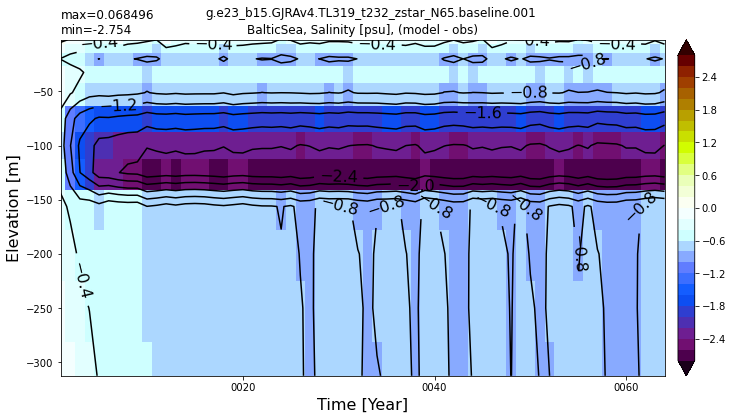

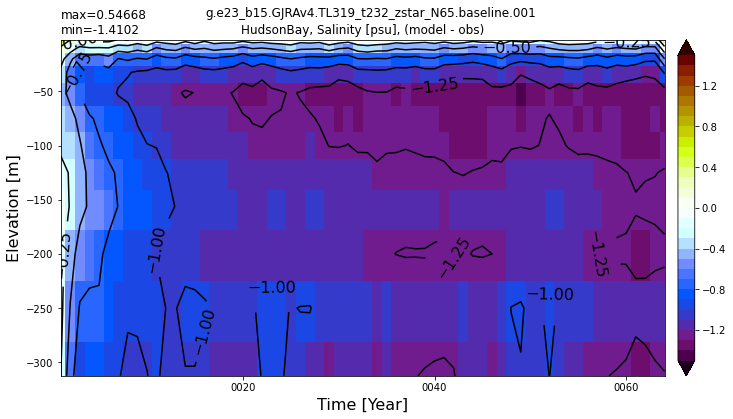

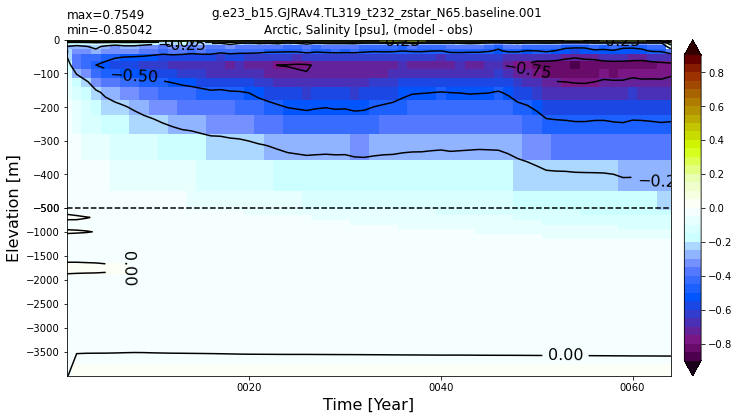

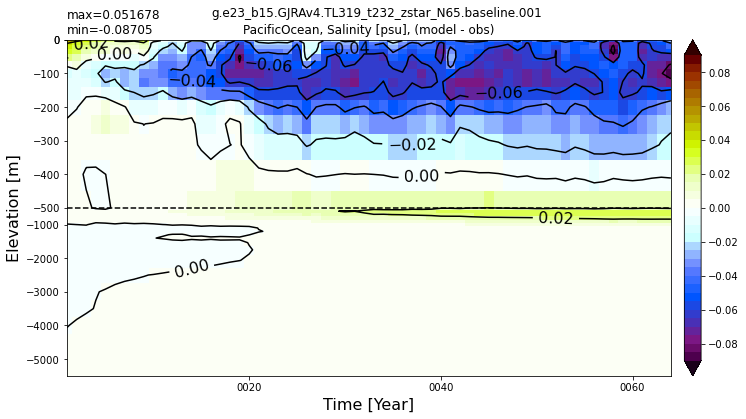

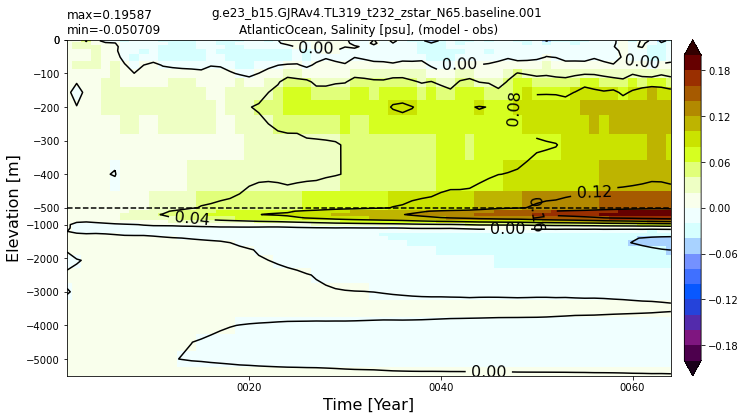

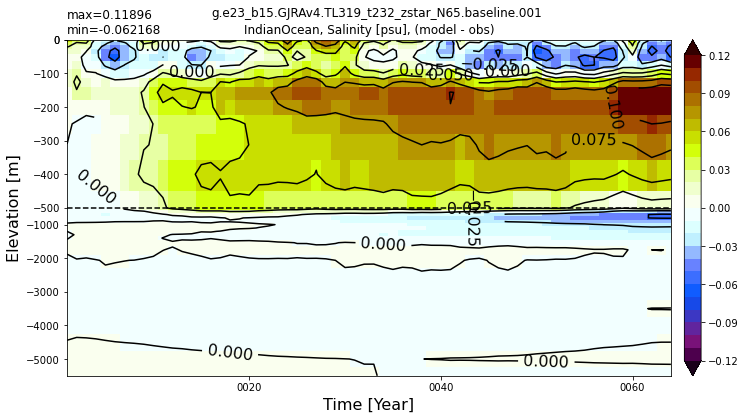

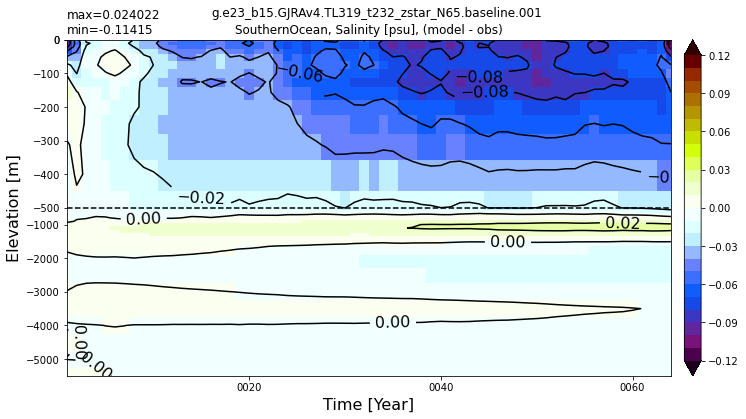

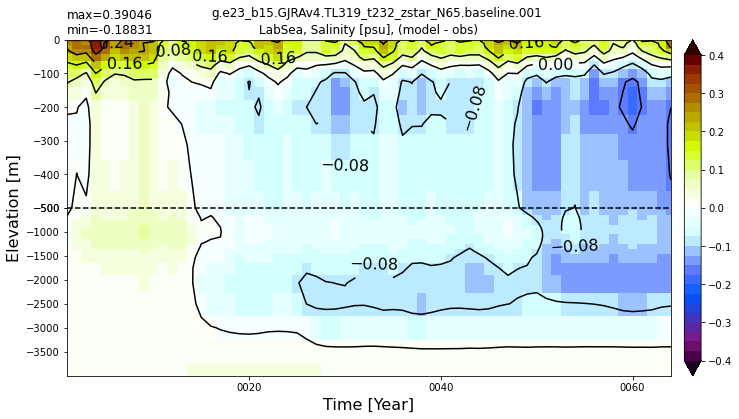

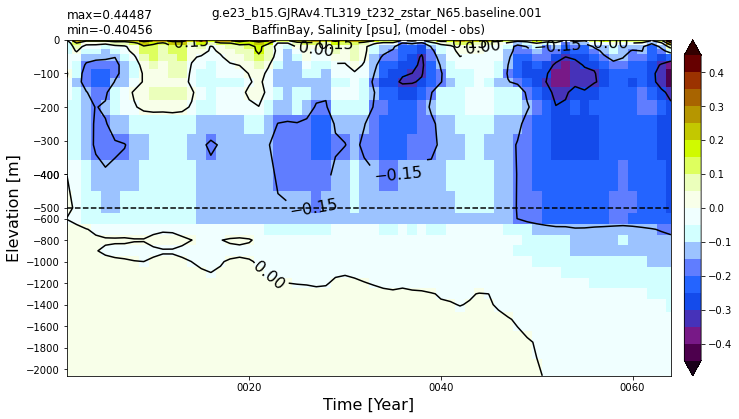

In [20]:
for reg in salt_bias.region:
    # remove Nan's
    diff_reg = salt_bias.sel(region=reg).dropna('z_l')
    if diff_reg.z_l.max() <= 500.0:
      splitscale = None
    else:
      splitscale =  [0., -500., -diff_reg.z_l.max()]

    ztplot(diff_reg.values, diff_reg.time.values, diff_reg.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
           suptitle=dcase._casename, contour=True,
           title= str(reg.values) + ', Salinity [psu], (model - obs)', 
           extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=True)

## Horizontal Mean RMSe (model - obs)

In [21]:
# TODO
#temp_rms = HorizontalMeanDiff_da(temp_diff,weights=area3d_masked, basins=basin_code)

## Temperature

In [22]:
for reg in temp_rms.region:
    # remove Nan's
    diff_reg = temp_rms.sel(region=reg).dropna('z_l')
    if diff_reg.z_l.max() <= 500.0:
      splitscale = None
    else:
      splitscale =  [0., -500., -diff_reg.z_l.max()]

    ztplot(diff_reg.values, diff_reg.time.values, diff_reg.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
           suptitle=dcase._casename, contour=True,
           title= str(reg.values) + ', Potential Temperature [C], RMSe', 
           extend='both', colormap='dunnePM', autocenter=False, tunits='Year', show=True)

NameError: name 'temp_rms' is not defined

In [ ]:
# TODO
#salt_rms = HorizontalMeanRmse_da(salt_diff,weights=area3d_masked, basins=basin_code)

## Salinity

In [ ]:
for reg in salt_rms.region:
    # remove Nan's
    diff_reg = salt_rms.sel(region=reg).dropna('z_l')
    if diff_reg.z_l.max() <= 500.0:
      splitscale = None
    else:
      splitscale =  [0., -500., -diff_reg.z_l.max()]

    ztplot(diff_reg.values, diff_reg.time.values, diff_reg.z_l.values*-1, ignore=np.nan, 
           splitscale=splitscale, suptitle=dcase._casename, contour=True,
           title= str(reg.values) + ', Salinity [psu], RMSe', extend='both', 
           colormap='dunnePM', autocenter=False, tunits='Year', show=True); 